In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
#import sklearn
#from sklearn.model_selection import train_test_split

In [ ]:
os.getcwd()

'/data/private/Thesis/May'

In [ ]:
# Set parameters
patch_size = 256
n_bands1 = 2
n_bands2 = 4
n_classes = 2
batch_size = 10
epochs = 50

In [ ]:
train_x1 = np.load('Data/03_Patch/train/x1.npy')
train_x2 = np.load('Data/03_Patch/train/x2.npy')
train_y = np.load('Data/03_Patch/train/y.npy')

In [ ]:
val_x1 = np.load('Data/03_Patch/val/x1.npy')
val_x2 = np.load('Data/03_Patch/val/x2.npy')
val_y = np.load('Data/03_Patch/val/y.npy')

In [ ]:
print(train_x1.shape)
print(val_x1.shape)
print(train_x2.shape)
print(val_x2.shape)
print(train_y.shape)
print(val_y.shape)

(1058, 256, 256, 2)
(529, 256, 256, 2)
(1058, 256, 256, 4)
(529, 256, 256, 4)
(1058, 256, 256, 1)
(529, 256, 256, 1)


In [ ]:
train_y[np.where( train_y < 1 )] = 0
labels, count = np.unique(train_y[:,:,0], return_counts=True)
print("Training labels are: ", labels, " and the counts are: ", count)

Training labels are:  [0. 1.]  and the counts are:  [ 75386 195462]


In [ ]:
val_y[np.where( val_y < 1 )] = 0
labels, count = np.unique(val_y[:,:,0], return_counts=True)
print("Validation labels are: ", labels, " and the counts are: ", count)

Validation labels are:  [0. 1.]  and the counts are:  [72066 63358]


In [ ]:
train_y = tf.keras.utils.to_categorical(train_y)
val_y = tf.keras.utils.to_categorical(val_y)

print(train_y.shape)
print(val_y.shape)

(1058, 256, 256, 2)
(529, 256, 256, 2)


In [ ]:
# BN_CONV_ReLU,Pool: Biswas. #CONV_BN_ReLU,Pool: Chibber. #CONV_BN_ReLU,CONV_BN_ReLU,Dropout,Pool: Practical
# conv1 = tf.keras.layers.Conv2D(n_filters=64, kernel_size=3, dilation_rate=1, activation='relu', padding='same')
# https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
def get_model(patch_size, n_bands1, n_bands2, n_classes):
    inputs1 = tf.keras.Input(shape=(patch_size, patch_size, n_bands1))
    inputs2 = tf.keras.Input(shape=(patch_size, patch_size, n_bands2))

    '''S1 Branch'''
    # ENCODER
    s1_conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs1)
    s1_conv1 = tf.keras.layers.BatchNormalization()(s1_conv1)
    s1_conv1 = tf.keras.layers.ReLU()(s1_conv1)
    s1_conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(s1_conv1)
    s1_conv1 = tf.keras.layers.BatchNormalization()(s1_conv1)
    s1_conv1 = tf.keras.layers.ReLU()(s1_conv1)
    s1_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(s1_conv1)

    s1_conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s1_pool1)
    s1_conv2 = tf.keras.layers.BatchNormalization()(s1_conv2)
    s1_conv2 = tf.keras.layers.ReLU()(s1_conv2)
    s1_conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s1_conv2)
    s1_conv2 = tf.keras.layers.BatchNormalization()(s1_conv2)
    s1_conv2 = tf.keras.layers.ReLU()(s1_conv2)
    s1_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(s1_conv2)

    s1_conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s1_pool2)
    s1_conv3 = tf.keras.layers.BatchNormalization()(s1_conv3)
    s1_conv3 = tf.keras.layers.ReLU()(s1_conv3)
    s1_conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s1_conv3)
    s1_conv3 = tf.keras.layers.BatchNormalization()(s1_conv3)
    s1_conv3 = tf.keras.layers.ReLU()(s1_conv3)
    s1_pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(s1_conv3)

    # BOTTOM
    s1_conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(s1_pool3)
    s1_conv4 = tf.keras.layers.BatchNormalization()(s1_conv4)
    s1_conv4 = tf.keras.layers.ReLU()(s1_conv4)
    s1_conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(s1_conv4)
    s1_conv4 = tf.keras.layers.BatchNormalization()(s1_conv4)
    s1_conv4 = tf.keras.layers.ReLU()(s1_conv4)

    # DECODER
    # BN_Conv2DTranspose_ReLU: Biswas. #Upsampling2D_Conv2DTranspose_BN_ReLU: Chibber. #Upsamling2D_CONV_BN_ReLU: Practical
    # deconv = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides)

    s1_deconv3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same')(s1_conv4)
    s1_merge3 = tf.keras.layers.concatenate([s1_conv3, s1_deconv3])
    s1_uconv3 = tf.keras.layers.BatchNormalization()(s1_merge3)
    s1_uconv3 = tf.keras.layers.ReLU()(s1_uconv3)
    s1_uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s1_uconv3)
    s1_uconv3 = tf.keras.layers.BatchNormalization()(s1_uconv3)
    s1_uconv3 = tf.keras.layers.ReLU()(s1_uconv3)
    s1_uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s1_uconv3)
    s1_uconv3 = tf.keras.layers.BatchNormalization()(s1_uconv3)
    s1_uconv3 = tf.keras.layers.ReLU()(s1_uconv3)

    s1_deconv2 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same')(s1_uconv3)
    s1_merge2 = tf.keras.layers.concatenate([s1_conv2, s1_deconv2])
    s1_uconv2 = tf.keras.layers.BatchNormalization()(s1_merge2)
    s1_uconv2 = tf.keras.layers.ReLU()(s1_uconv2)
    s1_uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s1_uconv2)
    s1_uconv2 = tf.keras.layers.BatchNormalization()(s1_uconv2)
    s1_uconv2 = tf.keras.layers.ReLU()(s1_uconv2)
    s1_uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s1_uconv2)
    s1_uconv2 = tf.keras.layers.BatchNormalization()(s1_uconv2)
    s1_uconv2 = tf.keras.layers.ReLU()(s1_uconv2)

    s1_deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same')(s1_uconv2)


    '''S2 Branch'''
    # ENCODER
    s2_conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs2)
    s2_conv1 = tf.keras.layers.BatchNormalization()(s2_conv1)
    s2_conv1 = tf.keras.layers.ReLU()(s2_conv1)
    s2_conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(s2_conv1)
    s2_conv1 = tf.keras.layers.BatchNormalization()(s2_conv1)
    s2_conv1 = tf.keras.layers.ReLU()(s2_conv1)
    s2_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(s2_conv1)

    s2_conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s2_pool1)
    s2_conv2 = tf.keras.layers.BatchNormalization()(s2_conv2)
    s2_conv2 = tf.keras.layers.ReLU()(s2_conv2)
    s2_conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s2_conv2)
    s2_conv2 = tf.keras.layers.BatchNormalization()(s2_conv2)
    s2_conv2 = tf.keras.layers.ReLU()(s2_conv2)
    s2_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(s2_conv2)

    s2_conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s2_pool2)
    s2_conv3 = tf.keras.layers.BatchNormalization()(s2_conv3)
    s2_conv3 = tf.keras.layers.ReLU()(s2_conv3)
    s2_conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s2_conv3)
    s2_conv3 = tf.keras.layers.BatchNormalization()(s2_conv3)
    s2_conv3 = tf.keras.layers.ReLU()(s2_conv3)
    s2_pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(s2_conv3)

    # BOTTOM
    s2_conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(s2_pool3)
    s2_conv4 = tf.keras.layers.BatchNormalization()(s2_conv4)
    s2_conv4 = tf.keras.layers.ReLU()(s2_conv4)
    s2_conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(s2_conv4)
    s2_conv4 = tf.keras.layers.BatchNormalization()(s2_conv4)
    s2_conv4 = tf.keras.layers.ReLU()(s2_conv4)

    # DECODER
    # BN_Conv2DTranspose_ReLU: Biswas. #Upsampling2D_Conv2DTranspose_BN_ReLU: Chibber. #Upsamling2D_CONV_BN_ReLU: Practical
    # deconv = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides)

    s2_deconv3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same')(s2_conv4)
    s2_merge3 = tf.keras.layers.concatenate([s2_conv3, s2_deconv3])
    s2_uconv3 = tf.keras.layers.BatchNormalization()(s2_merge3)
    s2_uconv3 = tf.keras.layers.ReLU()(s2_uconv3)
    s2_uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s2_uconv3)
    s2_uconv3 = tf.keras.layers.BatchNormalization()(s2_uconv3)
    s2_uconv3 = tf.keras.layers.ReLU()(s2_uconv3)
    s2_uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(s2_uconv3)
    s2_uconv3 = tf.keras.layers.BatchNormalization()(s2_uconv3)
    s2_uconv3 = tf.keras.layers.ReLU()(s2_uconv3)

    s2_deconv2 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same')(s2_uconv3)
    s2_merge2 = tf.keras.layers.concatenate([s2_conv2, s2_deconv2])
    s2_uconv2 = tf.keras.layers.BatchNormalization()(s2_merge2)
    s2_uconv2 = tf.keras.layers.ReLU()(s2_uconv2)
    s2_uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s2_uconv2)
    s2_uconv2 = tf.keras.layers.BatchNormalization()(s2_uconv2)
    s2_uconv2 = tf.keras.layers.ReLU()(s2_uconv2)
    s2_uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(s2_uconv2)
    s2_uconv2 = tf.keras.layers.BatchNormalization()(s2_uconv2)
    s2_uconv2 = tf.keras.layers.ReLU()(s2_uconv2)

    s2_deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same')(s2_uconv2)

    '''Fusion'''
    fu = tf.keras.layers.concatenate([s1_deconv1, s2_deconv1])

    '''Additional'''
    fu = tf.keras.layers.Conv2D(32, 3, padding='same')(fu)
    fu = tf.keras.layers.BatchNormalization()(fu)
    fu = tf.keras.layers.ReLU()(fu)
    fu = tf.keras.layers.Conv2D(32, 3, padding='same')(fu)
    fu = tf.keras.layers.BatchNormalization()(fu)
    fu = tf.keras.layers.ReLU()(fu)
    fu = tf.keras.layers.Conv2D(32, 3, padding='same')(fu)
    fu = tf.keras.layers.BatchNormalization()(fu)
    fu = tf.keras.layers.ReLU()(fu)

    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation="sigmoid")(fu)

    return tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model = get_model(patch_size, n_bands1, n_bands2, n_classes) # Get model

learning_rate=5e-6
decay_rate=learning_rate / epochs

# Compile as any Tensorflow model
model.compile(loss="binary_crossentropy", #binary_crossentropy,->for binary with n_class=1, background=NoData/Null
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

model.summary()

2023-05-16 18:20:41.531343: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1216        ['input_1[0][0]']                
                                )                                                             

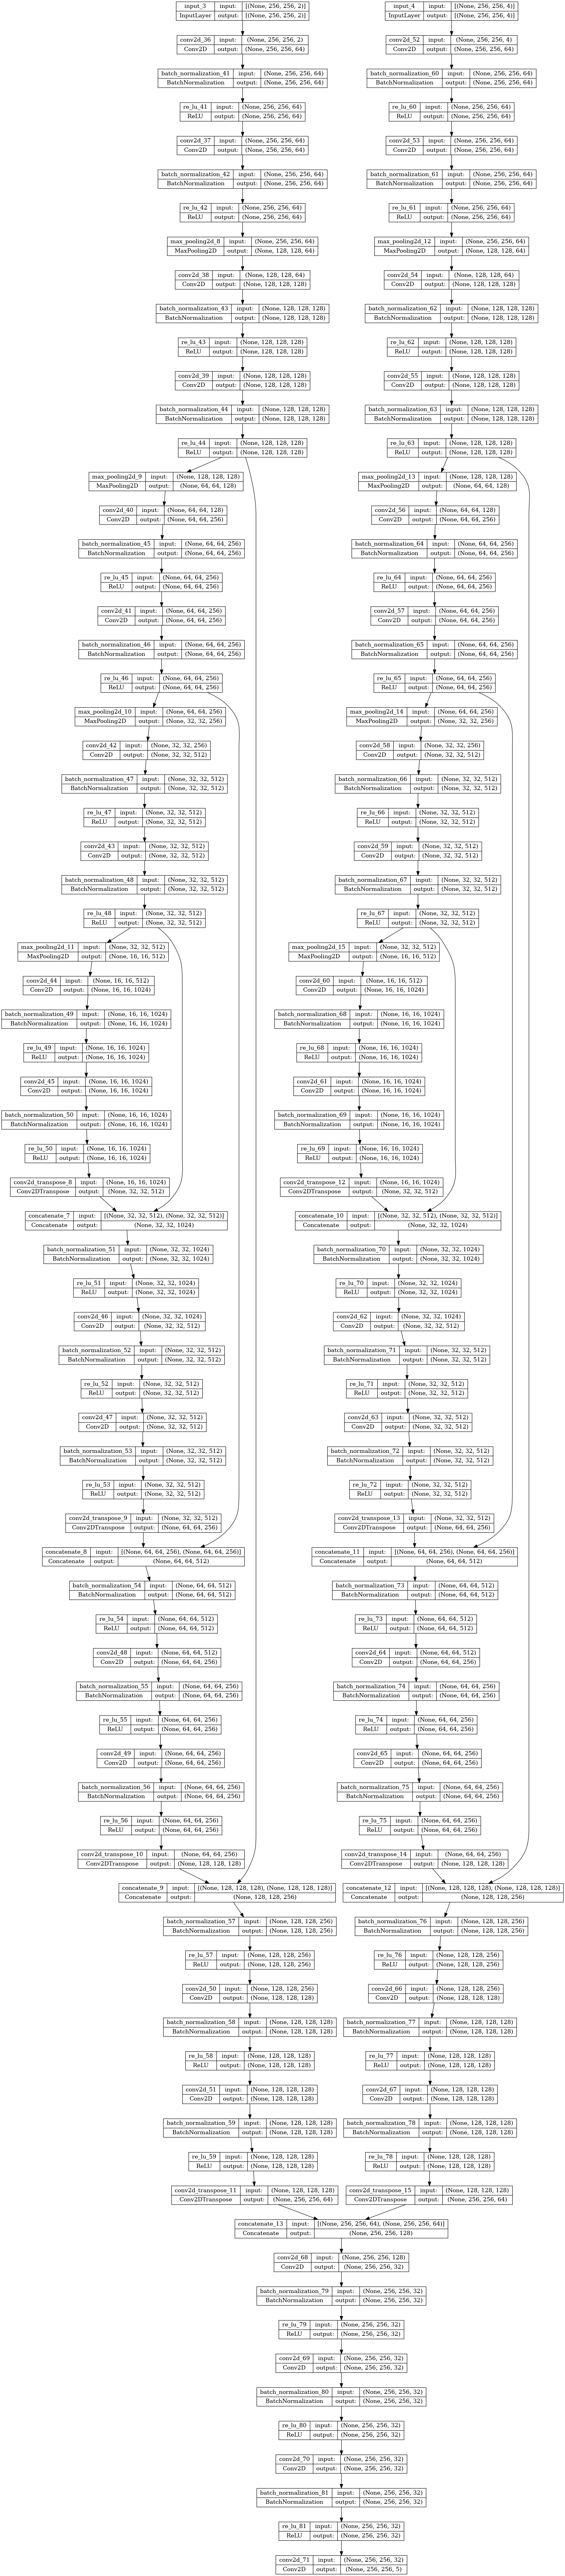

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
# Define callbacks parameters
conditions= [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='Model/slf_m_1e-5/modelfuslate.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
callbacks_list = [PlotLearning(), conditions]

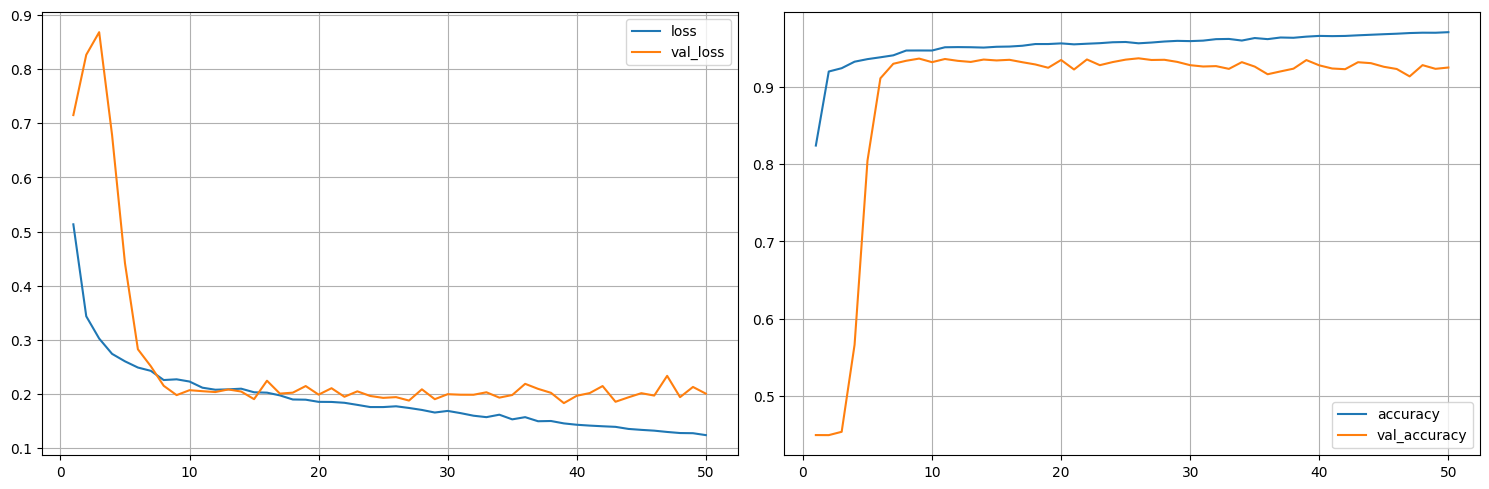

106/106 [==============================] - 47s 445ms/step - loss: 0.1244 - accuracy: 0.9707 - val_loss: 0.2009 - val_accuracy: 0.9250


In [ ]:
# Train and evaluate
history = model.fit(x=[train_x1, train_x2], y=train_y, batch_size=batch_size, epochs=epochs, #validation_split:0.2,
                    validation_data=([val_x1, val_x2], val_y), callbacks=callbacks_list, verbose=1)

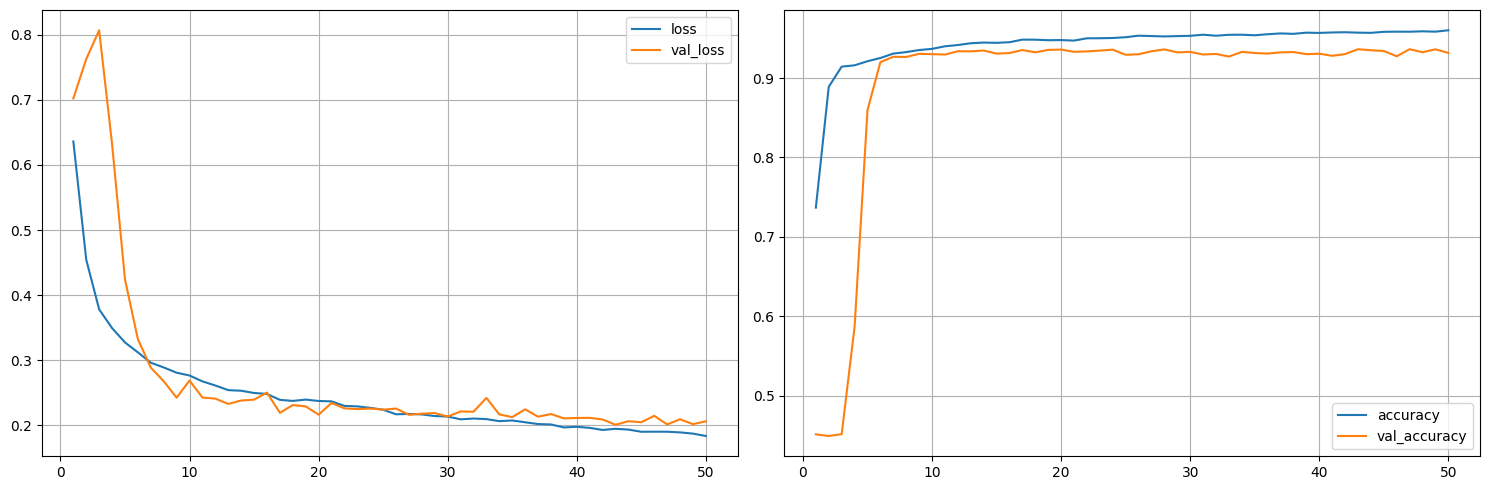

106/106 [==============================] - 47s 446ms/step - loss: 0.1838 - accuracy: 0.9601 - val_loss: 0.2063 - val_accuracy: 0.9317


In [ ]:
# Train and evaluate (5e-6)
history = model.fit(x=[train_x1, train_x2], y=train_y, batch_size=batch_size, epochs=epochs, #validation_split:0.2,
                    validation_data=([val_x1, val_x2], val_y), callbacks=callbacks_list, verbose=1)

In [ ]:
model = tf.keras.models.load_model("Model/slf_m_1e-5/modelfuslate.39-0.18.h5") #1e-5

In [ ]:
val_loss, val_acc = model.evaluate([val_x1, val_x2], val_y, batch_size=10)
print(f"\nValidation accuracy of U-Net: {100 * val_acc:.2f}%")

53/53 [==============================] - 7s 118ms/step - loss: 0.1835 - accuracy: 0.9346

Validation accuracy of U-Net: 93.46%


In [ ]:
model = tf.keras.models.load_model("Model/slf_m_1e-5/modelfuslate.43-0.20.h5") #5e-6

In [ ]:
val_loss, val_acc = model.evaluate([val_x1, val_x2], val_y, batch_size=10)
print(f"\nValidation accuracy of U-Net: {100 * val_acc:.2f}%")

53/53 [==============================] - 7s 116ms/step - loss: 0.2010 - accuracy: 0.9363

Validation accuracy of U-Net: 93.63%


In [ ]:
# https://stackoverflow.com/questions/51854463/is-it-possible-to-retrain-a-previously-saved-keras-model
model.save("Model/slf_m_1e-5_post/unetslf_relu_1e-5.h5")
#model.save_weights("unet_weights.h5")